# Figure S7 | Illustration of subsetting the ABC Altas to the thalamus dataset

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.append('/code/')
from abc_merfish_analysis import abc_load as abc
from abc_merfish_analysis import ccf_images as cimg

import seaborn as sns
import scipy.ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D

from matplotlib import rcParams
rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 7

%matplotlib inline

In [2]:
results_dir = '../../results'

In [3]:
cells_df = abc.get_combined_metadata(drop_unused=False)
print(f'n_cells in the whole-brain ABC Atlas: {cells_df.shape[0]}')

n_cells in the whole-brain ABC Atlas: 3739961


In [4]:
obs_th = abc.load_standard_thalamus(data_structure='obs')
print('n_cells in the thalamus dataset: ', obs_th.shape[0])

n_cells in the thalamus dataset:  80170


### Set up data structures for figure

In [5]:
cells_df_th_subset = abc.filter_by_thalamus_coords(cells_df, buffer=20, include_white_matter=True)

In [6]:
# This code is wrapped in the abc_load_base.label_ccf_spatial_subset() function

# loads the whole-brain CCF resampled_annotation image volumes
ccf_labels_img = abc.get_ccf_labels_image(resampled=True)

# get all parcellation names that are in either TH or ZI
ccf_regions_to_select = ['TH', 'ZI'] # TH = thalamus ; ZI = zona incerta
ccf_regions = abc.get_ccf_names(top_nodes=ccf_regions_to_select, 
                                level='substructure')
print(f'{ccf_regions=}')

# convert parcellation names to the unique parcellation_index used in the image volume
ccf_index = abc.get_ccf_index(level='substructure')
reverse_lookup = pd.Series(ccf_index.index.values, index=ccf_index)
th_zi_index_values = reverse_lookup.loc[ccf_regions]
print(f'{th_zi_index_values[:5]=} \netc. ...')

# generate a binary Thalamus mask
th_zi_mask = np.isin(ccf_labels_img, th_zi_index_values)

# get a version of the subset the ccf image volume using the binary mask
th_zi_labels_img = np.where(th_zi_mask, ccf_labels_img, 0)

# fills internal holes in the mask (usually, internal white matter tracts)
dist_for_TH = 2
th_zi_mask_filled = cimg.sectionwise_fill_holes(
            cimg.sectionwise_closing(th_zi_mask, distance_px=dist_for_TH)
            )

# dilate mask by specified buffer (1px=10um)
th_zi_mask_filled_dilated = cimg.sectionwise_dilation(th_zi_mask_filled, distance_px=2)

# clean up the binary mask to remove small, erroneous mask regions
th_zi_mask_filled_dilated_clean = cimg.cleanup_mask_regions(th_zi_mask_filled_dilated, 
                                                     area_ratio_thresh=0.1)

ccf_regions=array(['AD', 'AMd', 'AMv', 'AV', 'CL', 'CM', 'Eth', 'FF', 'IAD', 'IAM',
       'IGL', 'IMD', 'IntG', 'LD', 'LGd-co', 'LGd-ip', 'LGd-sh', 'LGv',
       'LH', 'LP', 'MD', 'MGd', 'MGm', 'MGv', 'MH', 'PCN', 'PF', 'PIL',
       'PO', 'POL', 'PP', 'PR', 'PT', 'PVT', 'PoT', 'RE', 'RH', 'RT',
       'SGN', 'SMT', 'SPA', 'SPFm', 'SPFp', 'SubG', 'TH-unassigned',
       'VAL', 'VM', 'VPL', 'VPLpc', 'VPM', 'VPMpc', 'Xi', 'ZI'],
      dtype='<U13')
th_zi_index_values[:5]=parcellation_term_acronym
AD       59
AMd    1085
AMv    1093
AV      248
CL      565
dtype: int64 
etc. ...


## Fig 1A: Filtering by CCF spatial coordinates

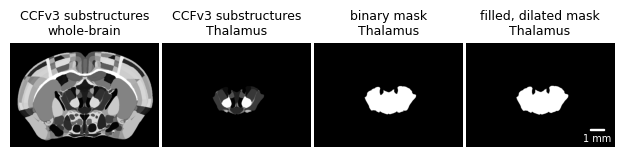

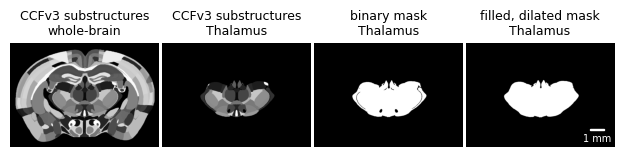

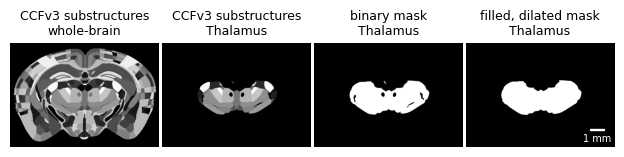

In [13]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

sections_example_3 = [8.0, 7.2, 6.4]

for sec in sections_example_3:
    sec_str = int(sec * 10)
    zindex = int(np.rint(sec / 0.2))

    # display the subsetted image volume and Thalamus binary mask
    fig, axes = plt.subplots(1, 4, figsize=(7.8, 2))
    axes = axes.ravel()

    # Subplot 1: Whole-brain CCF labels image
    axes[0].imshow(ccf_labels_img[:,:,zindex].T, cmap='gray')
    axes[0].set_title('CCFv3 substructures\nwhole-brain', fontsize=9)

    # Subplot 2: Thalamus subset of CCF labels image
    axes[1].imshow(th_zi_labels_img[:,:,zindex].T, cmap='gray')
    axes[1].set_title('CCFv3 substructures\nThalamus', fontsize=9)

    # Subplot 3: Thalamus binary mask
    axes[2].imshow(th_zi_mask[:,:,zindex].T, cmap='gray')
    axes[2].set_title('binary mask\nThalamus', fontsize=9)

    # Subplot 4: Thalamus binary mask - wm included, dilated
    axes[3].imshow(th_zi_mask_filled_dilated_clean[:,:,zindex].T, cmap='gray')
    axes[3].set_title('filled, dilated mask\nThalamus', fontsize=9)

    for ax in axes:
        ax.set_ylim(top=160, bottom=900)
        ax.set_xlim(left=20, right=1080)
        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
    
    scalebar = AnchoredSizeBar(axes[-1].transData,
                                100, '1 mm', 'lower right', 
                                pad=0.2,
                                sep=3,
                                color='white',
                                frameon=False,
                                size_vertical=10,
                                fontproperties=fm.FontProperties(size=7),
                                )
    axes[-1].add_artist(scalebar)
    
    plt.subplots_adjust(wspace=0.02)
    plt.show()


    fig.savefig(f'{results_dir}/figS7A_subset_by_ccf_z{sec_str}.pdf',
                transparent=True, bbox_inches='tight', dpi=1200)

In [8]:
# label cells that fall within the Thalamus mask
field_name='TH_ZI_dataset'
coords = ['x_reconstructed','y_reconstructed','z_reconstructed']
resolutions = np.array([10e-3, 10e-3, 200e-3])
cells_df[field_name] = th_zi_mask_filled_dilated_clean[cimg.image_index_from_coords(cells_df[coords], resolutions)]
# cells_df = abc_load_base._label_masked_cells(cells_df, th_zi_mask_dilated, coords, resolutions, field_name=field_name)

# filter out cells that do not fall within the Thalamus mask
th_zi_cells_df = cells_df[cells_df[field_name]].copy().drop(columns=[field_name])

print(f'n_cells after spatial filtering: {th_zi_cells_df.shape[0]}')

n_cells after spatial filtering: 162117


In [9]:
# filter cells from the anterior-most and posterior-most sections
sections_to_drop = ['C57BL6J-638850.29', 'C57BL6J-638850.46']

th_zi_cells_df = th_zi_cells_df[~th_zi_cells_df['brain_section_label'].isin(sections_to_drop)]

print(f'n_cells after section filtering: {th_zi_cells_df.shape[0]}')

n_cells after section filtering: 160663


## Fig 1B: Filtering by cell types

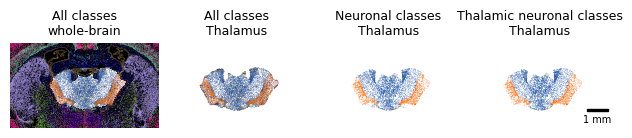

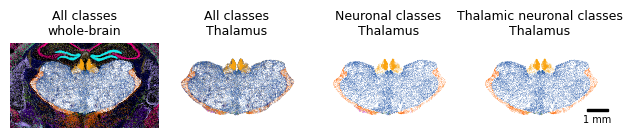

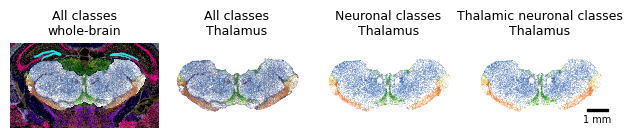

In [14]:
sections_example_3 = [8.0, 7.2, 6.4]

for sec in sections_example_3:
    sec_str = int(sec * 10)
    zindex = int(np.rint(sec / 0.2))
    
    # Set up figure
    fig, axes = plt.subplots(1, 4, figsize=(7.8,2))
    axes = axes.ravel()
    
    # Set defaults
    point_size = 0.5
    
    # Set up imshow colormaps
    bounds=[0,1]
    cmap_th_mask_show = colors.ListedColormap(['black', 'white'])
    norm_show = colors.BoundaryNorm(bounds, cmap_th_mask_show.N)
    cmap_th_mask_hide = colors.ListedColormap(['white', 'white'])
    norm_hide = colors.BoundaryNorm(bounds, cmap_th_mask_hide.N)
    
    # Subplot 1: Whole-brain CCF labels image
    axes[0].imshow(th_zi_mask_filled_dilated_clean[:,:,zindex].T, 
                   extent=[0, 11, 11, 0], 
                   zorder=0,
                   cmap=cmap_th_mask_show, 
                   norm=norm_show)
    curr_sec_df = cells_df[(cells_df['z_reconstructed']==sec)]                                    
    sc = axes[0].scatter(curr_sec_df['x_reconstructed'], 
                         curr_sec_df['y_reconstructed'],
                         color=curr_sec_df['class_color'],
                         s=point_size, 
                         marker='.',
                         edgecolors='none', 
                         zorder=1)
    
    # Subplot 2: All cells after filtering by TH mask
    axes[1].imshow(th_zi_mask_filled_dilated_clean[:,:,zindex].T, 
                   extent=[0, 11, 11, 0], 
                   zorder=0,
                   cmap=cmap_th_mask_hide, 
                   norm=norm_hide)
    curr_sec_df = th_zi_cells_df[(th_zi_cells_df['z_reconstructed']==sec)]                                    
    sc = axes[1].scatter(curr_sec_df['x_reconstructed'], 
                         curr_sec_df['y_reconstructed'],
                         color=curr_sec_df['class_color'],
                         s=point_size, 
                         marker='.',
                         edgecolors='none', 
                         zorder=1)
    
    # Subplot 3: Neurons after filtering by TH mask + filtering out NN classes
    axes[2].imshow(th_zi_mask_filled_dilated_clean[:,:,zindex].T, 
                   extent=[0, 11, 11, 0], 
                   zorder=0,
                   cmap=cmap_th_mask_hide, 
                   norm=norm_hide)
    neurons_test_df = abc.filter_by_class(th_zi_cells_df, exclude=abc.NN_CLASSES)
    curr_sec_df = neurons_test_df[(neurons_test_df['z_reconstructed']==sec)]                                    
    sc = axes[2].scatter(curr_sec_df['x_reconstructed'], 
                         curr_sec_df['y_reconstructed'],
                         color=curr_sec_df['class_color'],
                         s=point_size, 
                         marker='.',
                         edgecolors='none', 
                         zorder=1)
    
    # Subplot 4: TH neurons filtering out NN, non-TH classes
    axes[3].imshow(th_zi_mask_filled_dilated_clean[:,:,zindex].T, 
                   extent=[0, 11, 11, 0], 
                   zorder=point_size,
                   cmap=cmap_th_mask_hide, 
                   norm=norm_hide)
    th_mb_test_df = abc.filter_by_class(th_zi_cells_df, exclude=abc.NN_CLASSES,
                                       include=abc.TH_ZI_CLASSES+abc.MB_CLASSES)
    curr_sec_df = th_mb_test_df[(th_mb_test_df['z_reconstructed']==sec)]                                    
    sc = axes[3].scatter(curr_sec_df['x_reconstructed'], 
                         curr_sec_df['y_reconstructed'],
                         color=curr_sec_df['class_color'],
                         s=point_size, 
                         marker='.',
                         edgecolors='none', 
                         zorder=1)
    
    x_min = 2; x_max = 9; y_min = 7.5; y_max = 3.5
    for ax in axes:
        ax.set_xlim((x_min,x_max))
        ax.set_ylim((y_min,y_max))
        ax.axis('off')
        # ax.axis('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.subplots_adjust(wspace=0.02)
    
    # save a PNG version without the labels
    fig.savefig(f'{results_dir}/figS7B_subset_cells_by_class_z{sec_str}.png',
                transparent=True, bbox_inches='tight', dpi=1200)
    
    # add text-based labels
    # subplot titles
    axes[0].set_title('All classes\nwhole-brain', fontsize=9)
    axes[1].set_title('All classes\nThalamus', fontsize=9)
    axes[2].set_title('Neuronal classes\nThalamus', fontsize=9)
    axes[3].set_title('Thalamic neuronal classes\nThalamus', fontsize=9)
    # scalebar
    scalebar = AnchoredSizeBar(axes[-1].transData,
                                1, '1 mm', 'lower right', 
                                pad=0.2,
                                sep=3,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fm.FontProperties(size=7),
                                )
    axes[-1].add_artist(scalebar)
    # and now save a pdf version with the labels
    fig.savefig(f'{results_dir}/figS7B_subset_cells_by_class_z{sec_str}_labeled.pdf',   
                transparent=True, bbox_inches='tight', dpi=1200)

    plt.show()
    

## Supplemental Figure: Difference between binary mask & filled+dilated mask

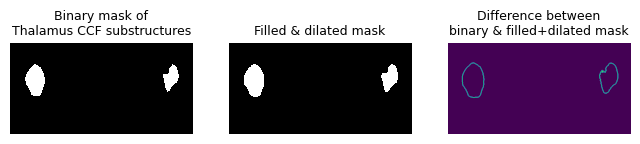

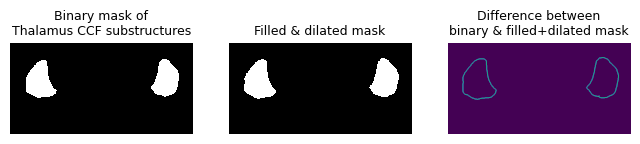

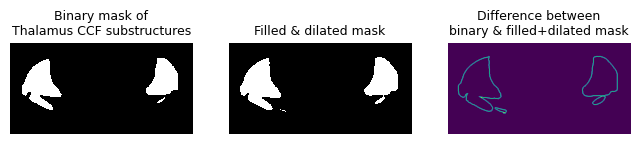

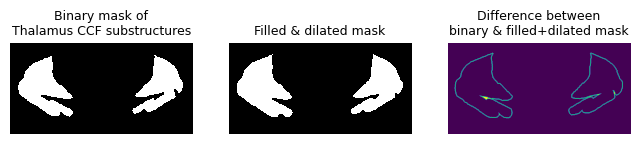

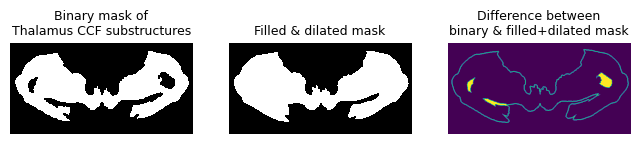

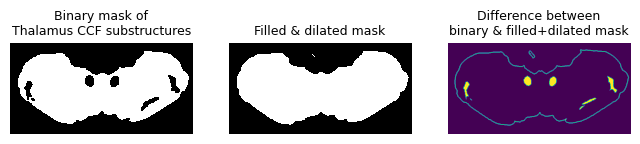

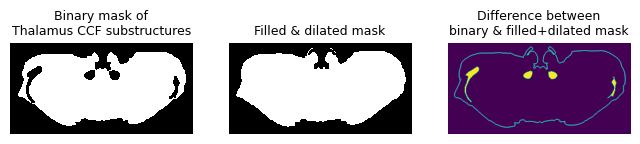

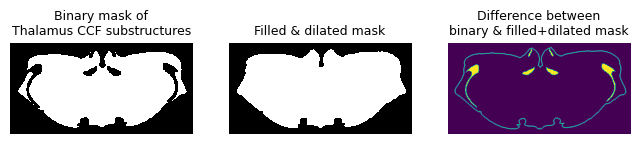

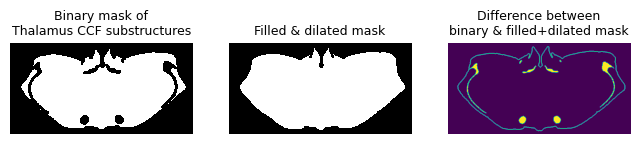

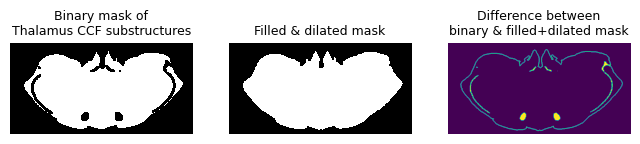

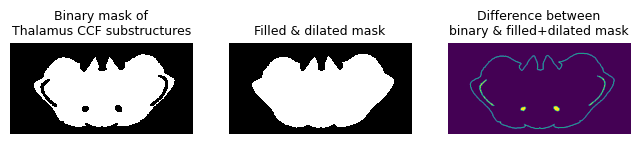

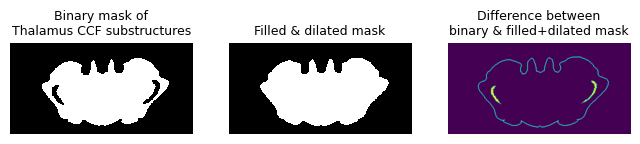

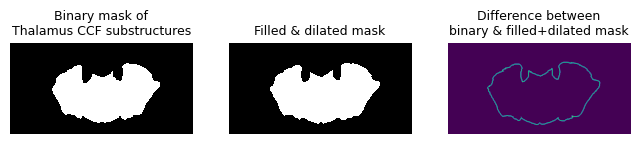

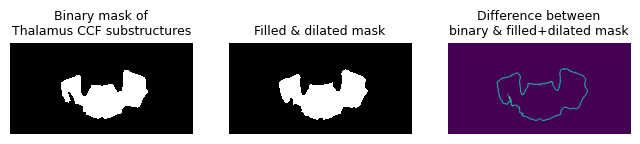

In [11]:
# mask_closed = ndi.binary_closing(th_zi_mask, iterations=20)
# mask_closed_filled = ndi.binary_fill_holes(mask_closed.copy(), structure=np.ones((3,3,3)))
sections = [5.0, 5.4, 5.6, 5.8, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.6, 7.8, 8.0, 8.2]

for sec in sections:
    sec_str = int(sec*10)
    
    sec_mask = th_zi_mask[:,:,int(np.rint(sec/0.2))].copy()
    sec_mask_closed = ndi.binary_closing(sec_mask.copy(), iterations=10)
    sec_mask_filled = ndi.binary_fill_holes(sec_mask.copy())
    sec_mask_closed_filled = ndi.binary_fill_holes(ndi.binary_closing(sec_mask.copy(), iterations=2))
    sec_mask_closed_filled_dilated = ndi.binary_dilation(ndi.binary_fill_holes(ndi.binary_closing(sec_mask.copy(), iterations=2)), iterations=2)
    sec_diff = np.logical_xor(1*sec_mask_closed_filled_dilated, 1*sec_mask)
    
    fig, axes = plt.subplots(1, 3, figsize=(8, 2))
    axes = axes.ravel()
    axes[0].imshow(sec_mask.T,
        extent=[0, 11, 11, 0],
        zorder=0,
        cmap=cmap_th_mask_show, 
        norm=norm_show)
    axes[0].set_title('Binary mask of\nThalamus CCF substructures', 
                      fontsize=9)
    
    axes[1].imshow(sec_mask_closed_filled_dilated.T,
        extent=[0, 11, 11, 0], 
        zorder=0,
        cmap=cmap_th_mask_show, 
        norm=norm_show)
    axes[1].set_title('Filled & dilated mask', 
                      fontsize=9)
    
    axes[2].imshow(sec_diff.T,
        extent=[0, 11, 11, 0], 
        zorder=0,
        )
    axes[2].set_title('Difference between\nbinary & filled+dilated mask',
                      fontsize=9)
    
    for ax in axes:
        ax.axis('off')
        ax.set_xlim((2.5,8.5))
        ax.set_ylim((7,4))
        
    plt.show()
    
    fig.savefig(f'{results_dir}/suppfig1_ccf_vs_mask_diff_z{sec_str}.pdf',   
                transparent=True, bbox_inches='tight', dpi=1200)